In [38]:
import numpy as np
from jesse import helpers, research

_, trading_1m = research.get_candles(
    "Binance Spot",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-01-01"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

print(trading_1m.shape)

np.save("data/btc_1m.npy", trading_1m)

(2630880, 6)


In [24]:
import numpy as np

candles = np.load("data/btc_1m.npy")
print(candles.shape)
candles[0, 0]


(2630880, 6)


1577836800000.0

In [25]:
import pandas as pd
from jesse.utils import numpy_candles_to_dataframe

df = numpy_candles_to_dataframe(candles)

# label
df["label"] = np.log(df["close"].shift(-1) / df["close"])

# high low range
df["hlr"] = np.log(df["high"] / df["low"])
df["log_hlr"] = np.log(df["hlr"] + 1)
df["sqrt_hlr"] = np.sqrt(df["hlr"] + 1) - 1

# abs return
ret_list = []
for i in range(1, 150):
    ret_series = np.log(df["close"] / df["close"].shift(i))
    ret_series.name = f"r{i}"
    ret_list.append(ret_series)

df = pd.concat([df, pd.concat(ret_list, axis=1)], axis=1)
del ret_list

# log return and sqrt return
log_sqrt_list = []
for i in range(1, 150):
    log_series = np.log(df[f"r{i}"] + 1)
    log_series.name = f"log_r{i}"
    log_sqrt_list.append(log_series)
    sqrt_series = np.sqrt(df[f"r{i}"] + 1) - 1
    sqrt_series.name = f"sqrt_r{i}"
    log_sqrt_list.append(sqrt_series)

df = pd.concat([df, pd.concat(log_sqrt_list, axis=1)], axis=1)
del log_sqrt_list

# data cleaning
df = df[df["r149"].notna()]
del candles
print(df.shape)

df.head()


(2630731, 457)


,date,open,close,high,low,volume,label,hlr,log_hlr,sqrt_hlr,...,log_r145,sqrt_r145,log_r146,sqrt_r146,log_r147,sqrt_r147,log_r148,sqrt_r148,log_r149,sqrt_r149
2020-01-01 02:29:00,2020-01-01 02:29:00,7233.19,7228.09,7233.57,7225.76,7.972429,0.000664,0.001080,0.001080,0.000540,...,0.006684,0.003347,0.005831,0.002920,0.006317,0.003164,0.006096,0.003052,0.005729,0.002869
2020-01-01 02:30:00,2020-01-01 02:30:00,7227.12,7232.89,7233.14,7226.79,4.631254,-0.000192,0.000878,0.000878,0.000439,...,0.007314,0.003664,0.007343,0.003678,0.006491,0.003251,0.006977,0.003494,0.006755,0.003383
2020-01-01 02:31:00,2020-01-01 02:31:00,7232.35,7231.50,7233.84,7229.47,13.106277,0.000176,0.000604,0.000604,0.000302,...,0.006845,0.003428,0.007123,0.003568,0.007152,0.003582,0.006300,0.003155,0.006786,0.003399
2020-01-01 02:32:00,2020-01-01 02:32:00,7231.69,7232.77,7233.14,7229.78,18.132154,-0.000151,0.000465,0.000465,0.000232,...,0.006790,0.003401,0.007019,0.003516,0.007297,0.003655,0.007326,0.003670,0.006475,0.003243
2020-01-01 02:33:00,2020-01-01 02:33:00,7232.06,7231.68,7236.07,7230.19,10.299170,0.000426,0.000813,0.000813,0.000406,...,0.006084,0.003047,0.006640,0.003326,0.006870,0.003441,0.007148,0.003580,0.007177,0.003595


In [26]:
data_check = np.load("data/btc_1m.npy")
# hlr_check = np.abs(np.log(data_check[:, 3] / data_check[:, 4]))
# r1_check = np.abs(np.log(data_check[1:, 2] / data_check[:-1, 2]))

data_check = data_check[149:]
# hlr_check = hlr_check[149:]
# r1_check = r1_check[149 - 1 :]

# data_check = data_check[(hlr_check > 0) & (r1_check > 0)]

assert data_check.shape[0] == df.shape[0]

In [34]:
# from custom_indicators.utils.plot import find_kde_cross

# target = np.log(df["close"] / df["close"].shift(149)).dropna()
# roots = find_kde_cross(target)


In [35]:
# label = (df["abs_r1p149"] >= 1.026490246399058236).astype(int)
# label.name = "label"
# label.sort_index(inplace=True)
# label.value_counts()

In [27]:
import warnings

from gplearn.fitness import make_fitness
from gplearn.genetic import SymbolicRegressor
from scipy import stats

from custom_indicators.toolbox.bar.build import (
    build_bar_by_threshold_greater_than,
    build_bar_by_threshold_less_than,
)


def gp_kurtosis(y, y_pred, w):
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    MIN_LENGTH = 1500

    if len(y_pred) <= 2:
        return 1000

    candles_in_metrics = np.load("data/btc_1m.npy")
    # h1r = np.abs(np.log(candles_in_metrics[:, 3] / candles_in_metrics[:, 4]))
    # r1 = np.abs(np.log(candles_in_metrics[1:, 2] / candles_in_metrics[:-1, 2]))
    candles_in_metrics = candles_in_metrics[149:]
    # h1r = h1r[149:]
    # r1 = r1[149 - 1 :]
    # candles_in_metrics = candles_in_metrics[(h1r > 0) & (r1 > 0)]
    candles_in_metrics = candles_in_metrics[:-1]

    assert len(candles_in_metrics) == len(y_pred), (
        f"{len(candles_in_metrics)} != {len(y_pred)}"
    )
    # sigmoid y_pred
    y_pred = 1 / (1 + np.exp(-y_pred))

    if all(y_pred > 0.5) or all(y_pred < 0.5):
        return 1000

    merged_bar_1 = build_bar_by_threshold_greater_than(
        candles_in_metrics,
        y_pred,
        0.5,
        reverse=False,
    )

    merged_bar_2 = build_bar_by_threshold_less_than(
        candles_in_metrics,
        y_pred,
        0.5,
        reverse=True,
    )

    if len(merged_bar_1) < MIN_LENGTH and len(merged_bar_2) < MIN_LENGTH:
        return 1000
    elif len(merged_bar_1) < MIN_LENGTH:
        log_ret_2 = np.log(merged_bar_2[1:, 2] / merged_bar_2[:-1, 2])
        std_log_ret_2 = (log_ret_2 - log_ret_2.mean()) / log_ret_2.std()
        kurtosis_2 = stats.kurtosis(std_log_ret_2)
        return kurtosis_2
    elif len(merged_bar_2) < MIN_LENGTH:
        log_ret_1 = np.log(merged_bar_1[1:, 2] / merged_bar_1[:-1, 2])
        std_log_ret_1 = (log_ret_1 - log_ret_1.mean()) / log_ret_1.std()
        kurtosis_1 = stats.kurtosis(std_log_ret_1)
        return kurtosis_1
    else:
        log_ret_1 = np.log(merged_bar_1[1:, 2] / merged_bar_1[:-1, 2])
        std_log_ret_1 = (log_ret_1 - log_ret_1.mean()) / log_ret_1.std()
        kurtosis_1 = stats.kurtosis(std_log_ret_1)
        log_ret_2 = np.log(merged_bar_2[1:, 2] / merged_bar_2[:-1, 2])
        std_log_ret_2 = (log_ret_2 - log_ret_2.mean()) / log_ret_2.std()
        kurtosis_2 = stats.kurtosis(std_log_ret_2)
        return min(kurtosis_1, kurtosis_2)


custom_kurtosis_loss = make_fitness(
    function=gp_kurtosis,
    greater_is_better=False,
    wrap=True,
)

cols = (
    ["hlr", "log_hlr", "sqrt_hlr"]
    + [f"r{i}" for i in range(1, 150)]
    + [f"log_r{i}" for i in range(1, 150)]
    + [f"sqrt_r{i}" for i in range(1, 150)]
)

est_gp = SymbolicRegressor(
    init_method="full",
    metric=custom_kurtosis_loss,
    population_size=12000,
    generations=20,
    tournament_size=50,
    stopping_criteria=0,
    function_set=["add", "sub", "abs", "neg", "max", "min"],
    p_crossover=0.7,
    p_subtree_mutation=0.12,
    p_hoist_mutation=0.06,
    p_point_mutation=0.12,
    max_samples=1,
    parsimony_coefficient=0.01,
    feature_names=cols,
    verbose=1,
    n_jobs=10,
    # random_state=233,
)

label = df["label"]

est_gp.fit(df[cols].iloc[:-1], label.iloc[:-1])

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.60           308.37       12          17.4748              N/A    195.78m
   1    39.31          176.016       51          15.2453              N/A    170.17m
   2    50.15          116.672       68          11.8045              N/A    155.00m
   3    40.75          119.422       68          11.6837              N/A    126.29m
   4    31.18          124.705       38          11.3234              N/A     97.67m
   5    34.42          120.442       38           9.5818              N/A     95.39m
   6    28.13          111.352       38           9.3089              N/A     82.97m
   7    35.55          100.035       72          9.17891              N/A     79.85m
   8    38.62          83.2254       68          8.97415              N/A  

KeyboardInterrupt: 

In [18]:
import pandas as pd

fitness_list = []
program_len_list = []
program_list = []

for lst in est_gp._programs:
    for program in lst:
        if program and program.fitness_ < 9:
            fitness_list.append(program.fitness_)
            program_len_list.append(len(str(program)))
            program_list.append(str(program))

df_res = pd.DataFrame(
    {"fitness": fitness_list, "len": program_len_list, "program": program_list}
).drop_duplicates(subset=["program"])
df_res.sort_values(by=["len", "fitness"], inplace=True)
df_res.head(10)


,fitness,len,program
60,8.382153,98,"sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(a..."
99,8.444538,98,"sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(a..."
62,8.566243,98,"sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(l..."
4068,8.848607,100,"sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(l..."
16,8.457514,102,"sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(a..."
0,8.575243,103,"sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(a..."
134,8.466514,107,"sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(a..."
104,8.408510,108,"sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(a..."
281,7.720791,112,"sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(a..."
306,7.720791,112,"sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(a..."


In [19]:
for fitness, program in zip(df_res["fitness"], df_res["program"]):
    print(f"{fitness = }: {program}")


fitness = 8.3821530827442: sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(abs(log_r42), max(log_r48, max(log_r108, log_r96)))))
fitness = 8.44453781658536: sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(abs(log_r42), max(log_r47, max(log_r108, log_r96)))))
fitness = 8.566243214459812: sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(log_r42, max(abs(log_r47), max(log_r108, log_r96)))))
fitness = 8.848607123493018: sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(log_r42, max(abs(log_r93), add(sqrt_r145, log_r113)))))
fitness = 8.457514040468253: sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(abs(log_r42), max(abs(log_r47), max(log_r48, log_r96)))))
fitness = 8.575243214459812: sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(abs(log_r42), max(abs(log_r47), max(log_r108, log_r96)))))
fitness = 8.466514040468253: sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(abs(log_r42), max(abs(abs(log_r47)), max(log_r48, log_r96)))))
fitness = 8.408509709949545: sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(abs(log_r42),

In [20]:
"""
abs(sqrt_r33 - log_r4) - (r42 - max(abs(log_r42), max(log_r48, max(log_r108, log_r96))))
"""
import numpy as np
from jesse import helpers, research
from jesse.utils import numpy_candles_to_dataframe

_, candles = research.get_candles(
    "Binance Spot",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2025-01-01"),
    helpers.date_to_timestamp("2025-05-01"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

print(candles.shape)

# hlr_check = np.abs(np.log(candles[:, 3] / candles[:, 4]))[1:]
# r1_check = np.abs(np.log(candles[1:, 2] / candles[:-1, 2]))
# candles = candles[1:]

# candles = candles[(hlr_check > 0) & (r1_check > 0)]

df = numpy_candles_to_dataframe(candles)
for i in [33, 4, 42, 48, 108, 96]:
    df[f"r{i}"] = np.abs(np.log(df["close"] / df["close"].shift(i)))
    df[f"log_r{i}"] = np.log(df[f"r{i}"] + 1)
    df[f"sqrt_r{i}"] = np.sqrt(df[f"r{i}"] + 1) - 1


df = df[df["r108"].notna()]
print(df.shape)


def get_gp_res(
    sqrt_r33,
    log_r4,
    r42,
    log_r42,
    log_r108,
    log_r48,
    log_r96,
):
    res = abs(sqrt_r33 - log_r4) - (
        r42 - max(abs(log_r42), max(log_r48, max(log_r108, log_r96)))
    )
    return res


res_list = []
for (
    sqrt_r33,
    log_r4,
    r42,
    log_r42,
    log_r108,
    log_r48,
    log_r96,
) in zip(
    df["sqrt_r33"],
    df["log_r4"],
    df["r42"],
    df["log_r42"],
    df["log_r108"],
    df["log_r48"],
    df["log_r96"],
):
    res = get_gp_res(
        sqrt_r33,
        log_r4,
        r42,
        log_r42,
        log_r108,
        log_r48,
        log_r96,
    )
    res = 1 / (1 + np.exp(-res))
    res_list.append(res)

df["res"] = res_list

df.head()

(172800, 6)
(172692, 24)


,date,open,close,high,low,volume,r33,log_r33,sqrt_r33,r4,...,r48,log_r48,sqrt_r48,r108,log_r108,sqrt_r108,r96,log_r96,sqrt_r96,res
2025-01-01 01:48:00,2025-01-01 01:48:00,93860.78,93826.35,93863.25,93822.46,4.92583,0.002577,0.002574,0.001288,0.001031,...,0.004828,0.004817,0.002411,0.002299,0.002296,0.001149,0.003277,0.003272,0.001637,0.500978
2025-01-01 01:49:00,2025-01-01 01:49:00,93826.35,93854.48,93854.48,93826.34,2.47486,0.001676,0.001675,0.000838,0.000809,...,0.003887,0.003880,0.001942,0.002160,0.002157,0.001079,0.003308,0.003303,0.001653,0.500670
2025-01-01 01:50:00,2025-01-01 01:50:00,93854.47,93750.34,93854.48,93750.33,10.77828,0.002470,0.002467,0.001234,0.002063,...,0.004652,0.004641,0.002323,0.000514,0.000514,0.000257,0.001005,0.001004,0.000502,0.500747
2025-01-01 01:51:00,2025-01-01 01:51:00,93750.34,93711.69,93750.34,93682.84,38.00424,0.002848,0.002844,0.001423,0.001590,...,0.004591,0.004581,0.002293,0.000360,0.000360,0.000180,0.000101,0.000101,0.000050,0.500255
2025-01-01 01:52:00,2025-01-01 01:52:00,93711.68,93636.41,93711.70,93578.77,27.49274,0.003772,0.003765,0.001884,0.002026,...,0.005134,0.005121,0.002564,0.000265,0.000265,0.000132,0.001405,0.001404,0.000702,0.500135


In [21]:
candles.shape[0] - df.shape[0]

108

In [22]:
(df["res"] > 0.5).astype(int).value_counts()

res
1    172575
0       117
Name: count, dtype: int64

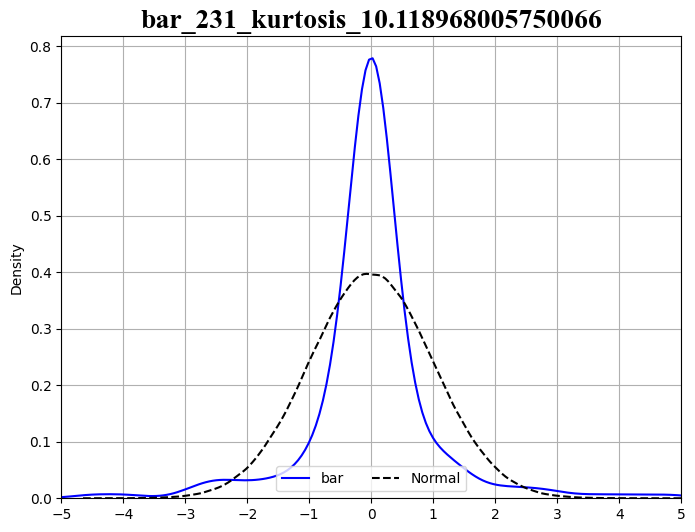

In [23]:
from custom_indicators.utils.plot import plot_kde

merged_bar = build_bar_by_threshold_less_than(
    candles[108:], df["res"].tolist(), 0.5, reverse=False
)

plot_kde(merged_bar[:, 2])

In [17]:
from jesse.utils import numpy_candles_to_dataframe
from lightweight_charts import Chart

df_merged_bar = numpy_candles_to_dataframe(merged_bar)
df_merged_bar.head()

chart = Chart()
chart.set(df_merged_bar[["date", "open", "high", "low", "close", "volume"]])
chart.show(block=True)


RuntimeError: asyncio.run() cannot be called from a running event loop